## Imports

In [1]:
using BenchmarkTools, Plots, Statistics
include("primality_tests.jl");

In [2]:
range_to_search = 2^27:2^28

134217728:268435456

## Generate primes with trial division

In [3]:
@timev trial_division_primes = [n for n in range_to_search if trial_division_improved(n)]
trial_division_primes_set = Set(trial_division_primes)

138.669811 seconds (86.62 k allocations: 78.263 MiB, 0.02% gc time, 0.02% compilation time)
elapsed time (ns):  138669810900
gc time (ns):       30444200
bytes allocated:    82064325
pool allocs:        86587
non-pool GC allocs: 31
malloc() calls:     1
realloc() calls:    6
free() calls:       9
minor collections:  0
full collections:   1


Set{Int64} with 7027290 elements:
  160194443
  257106557
  263880713
  208961549
  246707863
  232420219
  243291443
  146704793
  260836091
  152654641
  186002497
  248117167
  139631017
  189284699
  174094913
  232245389
  201308183
  263409343
  238141619
  148930361
  189589571
  265409407
  218319809
  217984939
  189764101
  ⋮ 

These numbers are guaranteed to be prime, but often take a while to execute

## Find numbers that pass Fermat primality test

In [4]:
k = 3
@timev fermat_passing_numbers = [n for n in range_to_search if fermat_test(n,k)]
fermat_passing_numbers_set = Set(fermat_passing_numbers)

 56.717420 seconds (201.58 M allocations: 7.022 GiB, 1.54% gc time, 0.13% compilation time)
elapsed time (ns):  56717420100
gc time (ns):       875304900
bytes allocated:    7539772001
pool allocs:        201575110
non-pool GC allocs: 47
malloc() calls:     1
realloc() calls:    6
free() calls:       53
minor collections:  37
full collections:   1


Set{Int64} with 7027376 elements:
  160194443
  257106557
  263880713
  208961549
  246707863
  232420219
  243291443
  146704793
  260836091
  152654641
  186002497
  248117167
  139631017
  189284699
  174094913
  232245389
  201308183
  263409343
  238141619
  148930361
  189589571
  265409407
  218319809
  217984939
  189764101
  ⋮ 

Note that it ran significantly faster than trial division. However, some accuracy is lost. Let's compare to the primes guaranteed by trial division

In [5]:
fermat_false_positives = setdiff(fermat_passing_numbers_set, trial_division_primes_set)

Set{Int64} with 86 elements:
  151813201
  176659201
  196358977
  150846961
  257495641
  158864833
  186782401
  186393481
  163759753
  206955841
  226509361
  181154701
  157731841
  180115489
  221884001
  266003101
  140241361
  172947529
  184353001
  170947105
  185040703
  232114433
  172290241
  166595131
  139536865
  ⋮ 

In [6]:
fermat_false_negatives = setdiff(trial_division_primes_set, fermat_passing_numbers_set)

Set{Int64}()

As demonstrated, the Fermat test can often give false positive but not false negatives.

## Find numbers that pass Miller-Rabin test

In [7]:
k = 4
@timev mr_passing_numbers = [n for n in range_to_search if miller_rabin_test(n,k)]
mr_passing_numbers_set = Set(mr_passing_numbers)

 67.426702 seconds (201.47 M allocations: 8.026 GiB, 1.51% gc time, 0.07% compilation time)
elapsed time (ns):  67426702200
gc time (ns):       1015301300
bytes allocated:    8617550401
pool allocs:        201470839
non-pool GC allocs: 42
malloc() calls:     1
realloc() calls:    6
free() calls:       5
minor collections:  17
full collections:   2


Set{Int64} with 7027291 elements:
  160194443
  257106557
  263880713
  208961549
  246707863
  232420219
  243291443
  146704793
  260836091
  152654641
  186002497
  248117167
  139631017
  189284699
  174094913
  232245389
  201308183
  263409343
  238141619
  148930361
  189589571
  265409407
  218319809
  217984939
  189764101
  ⋮ 

In [8]:
mr_false_positives = setdiff(mr_passing_numbers_set, trial_division_primes_set)

Set{Int64} with 1 element:
  165938653

In [9]:
mr_false_negatives = setdiff(trial_division_primes_set, mr_passing_numbers_set)

Set{Int64}()

Again, the Miller-Rabin test doesn't give false negatives. It is possible that it returns a false positive but the chance is much lower than the Fermat test. Increasing the number of trials increases confidence that a number is truely prime, but will cost more time. With the parameters I chose, it runs slightly longer than the Fermat test, but still significantly faster than trial division

## Speed of a single test
The prior cells showed the time taken to generate all primes in a certain range (and store them in a Vector). Now we will look closely at the speed performance of each test using BenchmarkTools

In [10]:
# Select a large (certainly prime) number
prime_to_time = trial_division_primes[length(trial_division_primes)]

268435399

In [11]:
@btime trial_division_basic(prime_to_time)

  489.995 ms (0 allocations: 0 bytes)


true

In [12]:
@btime trial_division_improved(prime_to_time)

  16.400 μs (0 allocations: 0 bytes)


true

Here, the improved version of trial division was over 1000 times faster than the basic version.

In [13]:
k = 3
@btime fermat_test(prime_to_time,k)

  1.800 μs (1 allocation: 80 bytes)


true

In [14]:
k = 3
@btime miller_rabin_test(prime_to_time,k)

  1.830 μs (1 allocation: 80 bytes)


true

Here, the times taken by the Fermat test and the Miller-Rabin test are very close since they each only used 3 bases.

## Liars
Both the Fermat test and the Miller-Rabin test are probabilistic tests. We will now examine a few composite numbers and how many bases they pass in each test.

In [15]:
composite1 = 35;#35=5*7

In [16]:
number_witnesses = number_liars = 0

n = composite1
println("Searching for Fermat liars for n=$(n)")

for a in 2:n-2
    if _fermat_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for Fermat liars for n=35
Liar at a=6
Liar at a=29
30 witnesses, 2 liars


In [17]:
number_witnesses = number_liars = 0

n = composite1
println("Searching for strong liars for n=$(n)")

for a in 2:n-2
    if _miller_rabin_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for strong liars for n=35
32 witnesses, 0 liars


For the Fermat test, there were 2 liars that allowed 35 to be marked as possibly prime. Meanwhile the Miller-Rabin test had none.

Let's try another number.

In [18]:
composite2 = 221;#221=13*17

In [19]:
number_witnesses = number_liars = 0

n = composite2
println("Searching for Fermat liars for n=$(n)")

for a in 2:n-2
    if _fermat_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for Fermat liars for n=221
Liar at a=18
Liar at a=21
Liar at a=38
Liar at a=47
Liar at a=64
Liar at a=86
Liar at a=103
Liar at a=118
Liar at a=135
Liar at a=157
Liar at a=174
Liar at a=183
Liar at a=200
Liar at a=203
204 witnesses, 14 liars


In [20]:
number_witnesses = number_liars = 0

n = composite2
println("Searching for strong liars for n=$(n)")

for a in 2:n-2
    if _miller_rabin_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for strong liars for n=221
Liar at a=21
Liar at a=47
Liar at a=174
Liar at a=200
214 witnesses, 4 liars


For 221, the Fermat test had 14 liars whereas the Miller-Rabin test had 4. Also note that for a fixed $n$, the set of Miller-Rabin liars is a subset of the Fermat liars.

In [21]:
composite3 = 561;#561=3*11*17

In [22]:
number_witnesses = number_liars = 0

n = composite3
println("Searching for Fermat liars for n=$(n)")

for a in 2:n-2
    if _fermat_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for Fermat liars for n=561
Liar at a=2
Liar at a=4
Liar at a=5
Liar at a=7
Liar at a=8
Liar at a=10
Liar at a=13
Liar at a=14
Liar at a=16
Liar at a=19
Liar at a=20
Liar at a=23
Liar at a=25
Liar at a=26
Liar at a=28
Liar at a=29
Liar at a=31
Liar at a=32
Liar at a=35
Liar at a=37
Liar at a=38
Liar at a=40
Liar at a=41
Liar at a=43
Liar at a=46
Liar at a=47
Liar at a=49
Liar at a=50
Liar at a=52
Liar at a=53
Liar at a=56
Liar at a=58
Liar at a=59
Liar at a=61
Liar at a=62
Liar at a=64
Liar at a=65
Liar at a=67
Liar at a=70
Liar at a=71
Liar at a=73
Liar at a=74
Liar at a=76
Liar at a=79
Liar at a=80
Liar at a=82
Liar at a=83
Liar at a=86
Liar at a=89
Liar at a=91
Liar at a=92
Liar at a=94
Liar at a=95
Liar at a=97
Liar at a=98
Liar at a=100
Liar at a=101
Liar at a=103
Liar at a=104
Liar at a=106
Liar at a=107
Liar at a=109
Liar at a=112
Liar at a=113
Liar at a=115
Liar at a=116
Liar at a=118
Liar at a=122
Liar at a=124
Liar at a=125
Liar at a=127
Liar at a=128
Liar at a=130
L

In [23]:
sum(i->gcd(i,n)==1,2:n-2)

318

In [24]:
number_witnesses = number_liars = 0

n = composite3
println("Searching for strong liars for n=$(n)")

for a in 2:n-2
    if _miller_rabin_trial(n,a)
        println("Liar at a=$(a)")
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("$(number_witnesses) witnesses, $(number_liars) liars")


Searching for strong liars for n=561
Liar at a=50
Liar at a=101
Liar at a=103
Liar at a=256
Liar at a=305
Liar at a=458
Liar at a=460
Liar at a=511
550 witnesses, 8 liars


561 is a Carmichael number, which basically means that it fools the Fermat primality test whenever $(a,n)=1$. In this example, the chance that a single Fermat trial gives a false positive is $\frac{318}{558}$. Meanwhile the Miller-Rabin test only has 8 liars in the range.

In [25]:
composite4 = 196287391;#196287391=9907*19813
bases_to_test = 10^6;

In [26]:
number_witnesses = number_liars = 0

n = composite4
println("Searching for Fermat liars for n=$(n)")

for a in rand(2:n-2,bases_to_test)
    if _fermat_trial(n,a)
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("~$(number_witnesses/bases_to_test*100)% witnesses, ~$(number_liars/bases_to_test*100)% liars")


Searching for Fermat liars for n=196287391
~49.9867% witnesses, ~50.01330000000001% liars


In [27]:
number_witnesses = number_liars = 0

n = composite4
println("Searching for strong liars for n=$(n)")

for a in rand(2:n-2,bases_to_test)
    if _miller_rabin_trial(n,a)
        number_liars += 1
    else
        number_witnesses += 1
    end
end

println("~$(number_witnesses/bases_to_test*100)% witnesses, ~$(number_liars/bases_to_test*100)% liars")


Searching for strong liars for n=196287391
~75.0371% witnesses, ~24.962899999999998% liars


This demonstrates that for composite numbers, a single Miller-Rabin trial has at most a 25% of returning a false positive. Interestingly, 196287391 is not a Carmichael number.

In [28]:
nums_to_test = 10^6
bases_to_test = 10^2
fermat_liar_rate = zeros(nums_to_test)
miller_rabin_liar_rate = zeros(nums_to_test)
range_to_test = 5:2^27

for i in 1:nums_to_test
    fermat_liars = 0
    miller_rabin_liars = 0

    n = rand(range_to_test)
    while trial_division_improved(n)
        n = rand(range_to_test)
    end

    for a in rand(2:n-2,bases_to_test)
        if _miller_rabin_trial(n,a)
            miller_rabin_liars += 1
            fermat_liars += 1
        elseif _fermat_trial(n,a)
            fermat_liars += 1
        end
    end

    fermat_liar_rate[i] = fermat_liars/bases_to_test
    miller_rabin_liar_rate[i] = miller_rabin_liars/bases_to_test
end

0.84


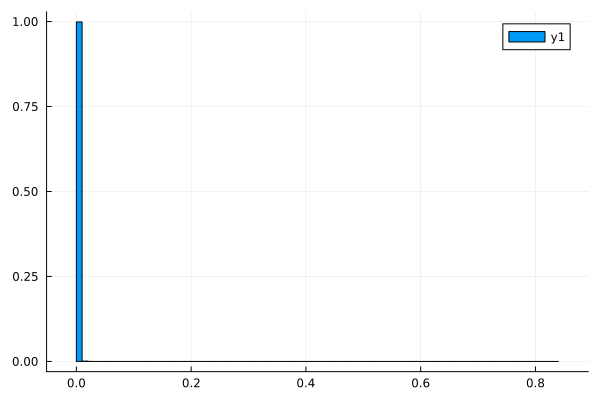

In [29]:
bins = 0:.01:maximum(fermat_liar_rate)
println(maximum(fermat_liar_rate))
histogram(fermat_liar_rate,bins=bins,normalize=:probability)

0.25


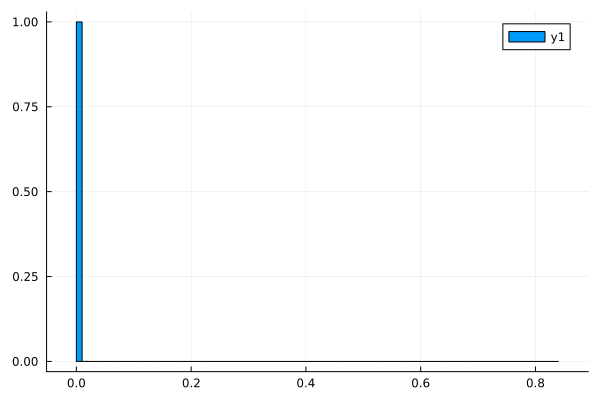

In [30]:
println(maximum(miller_rabin_liar_rate))
histogram(miller_rabin_liar_rate,bins=bins,normalize=:probability)

In [31]:
mean(miller_rabin_liar_rate)

4.75e-6